## GAAIMS: Predicting Multiple Sclerosis from Dynamics of Gait Variability Using an Instrumented Treadmill - A Machine Learning-Based Approach

### Disease progression in (raw, size-N, regress-N) data as seen in EDSS/age/walking speed 


### Package imports 

In [1]:
import os
import math
import pandas as pd
import numpy as np
from sklearn import mixture
import matplotlib.pyplot as plt
from sklearn import decomposition
import seaborn as sns 
import matplotlib as mpl
from sklearn.decomposition import PCA as sklearnPCA
import warnings
from sklearn import manifold
import matplotlib.gridspec as gridspec
warnings.filterwarnings("ignore")

In [2]:
path = 'C:\\Users\\Rachneet Kaur\\Dropbox\\GAIT\\sample_data\\data_export\\'

In [3]:
# #Reading the raw dataframe 
# raw_df = pd.read_csv(path+'..\\..\\FinalCodes\\gait_features.csv', index_col = 0)
# #Dropping the NaNs
# raw_df.dropna(inplace = True)
# #Resetting the index
# raw_df.reset_index(inplace= True)
# print ('Raw data shape: ', raw_df.shape)

# #Reading the Size-N dataframe 
# sizeN_df = pd.read_csv(path+'..\\..\\FinalCodes\\size_normalized_gait_features.csv', index_col = 0)
# #Dropping the NaNs
# sizeN_df.dropna(inplace = True)
# #Resetting the index
# sizeN_df.reset_index(inplace= True)
# print ('Size-N data shape: ', sizeN_df.shape)

#Reading the Regress-N dataframe 
regressN_df = pd.read_csv(path+'..\\..\\FinalCodes\\csv files\\mr_scaled_features_30controlsTrialW.csv', index_col = 0)
regressN_df.reset_index(inplace= True)
print('Regress-N data shape: ', regressN_df.shape)

#Reading the demographics of the subjects
demographies = pd.read_csv(path + '..\\demographics.csv')

#Keeping demographics of only the 35 subjects we have the raw data for 
demographies = demographies[demographies['subject ID'].isin(regressN_df['PID'].unique())]

#Reading the EDSS scores for PwMS 
edss= pd.read_csv('edss.csv')
#Keeping edss of only the 17 PwMS subjects we have the raw data for 
edss = edss[edss['PID'].isin(regressN_df[regressN_df['Label']==1]['PID'].unique())].reset_index().drop('index', axis =1)

Regress-N data shape:  (3230, 25)


In [4]:
#Delete the treadmill speeds as features since they are very very correlated with stride speed
#Also delete Butterfly plot y-direction features since COP_Y is not adjusted 
#Swing time and SS_L are the same
to_drop = ['tspeed_HSR', 'tspeed_MidSSR', 'tspeed_TOR', 'tspeed_HSL', 'tspeed_TOL', 'tspeed_MidSSL',  'Butterfly_y_abs', 
           'ButterflySQ_y', 'SS_L']
# raw_df.drop(to_drop, axis = 1, inplace= True)
# sizeN_df.drop(to_drop, axis = 1, inplace= True)
# regressN_df.drop(to_drop, axis = 1, inplace= True)

#Normalize all features and dataframes between 0 and 1 to plot on same plot
#All features we need to vizualize 
#Only angles can be negative, rest all features are +ve only 
#So we normalize all features which are +ve between 0 and 1 and then plot on same graph 
#Also, angles we have vizualized already, so can skip those 
#Hence we have 21 total features but we do not vizualize angles and Butterfly features 
features = ['stride_time', 'stance_time', 'swing_time', 'SS_R', 'DS_R', 'DS_L', 'cadence', 'stride_length', 'stride_width',
       'LeftFPA', 'RightFPA', 'stride_speed',  'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR',
       'force_HSL', 'force_TOR', 'force_MidSSL','Butterfly_x_abs', 'ButterflySQ_x']
#Min-Max normalization 
# raw_df_normal = (raw_df[features]- raw_df[features].min(axis = 0))/(raw_df[features].max(axis = 0) - raw_df[features].min(axis = 0))
# sizeN_df_normal = (sizeN_df[features]- sizeN_df[features].min(axis = 0))/(sizeN_df[features].max(axis = 0) - sizeN_df[features].min(axis = 0))
regressN_df_normal = (regressN_df[features]- regressN_df[features].min(axis = 0))/(regressN_df[features].max(axis = 0) - regressN_df[features].min(axis = 0))

#17 total features (normalized) to visualize (except angles)
regressN_df_normal.columns

Index(['stride_time', 'stance_time', 'swing_time', 'SS_R', 'DS_R', 'DS_L',
       'cadence', 'stride_length', 'stride_width', 'LeftFPA', 'RightFPA',
       'stride_speed', 'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR',
       'force_HSL', 'force_TOR', 'force_MidSSL', 'Butterfly_x_abs',
       'ButterflySQ_x'],
      dtype='object')

## Trial W

### We make progression spaces for trial W and WT separately only using the regress-N data and only uisng the PwMS, since we construct an MS progression space only.

In [5]:
#Selecting the dataset - Only PwMS in trial W
dataset_W = regressN_df_normal[(regressN_df['TrialID']==1) & (regressN_df['Label']==1)] #RegressN - Trial W #['Label'==1] for see progression on only MS (second plot)


#Attaching the EDSS to the corresponding subjects 
dataset_W['edss'] = regressN_df['PID'].map(edss.set_index('PID')['EDSS'])
dataset_W['color'] = 'r' #Initially all red
dataset_W['color'][dataset_W[regressN_df['Label']==0].index] = 'g' #Green for controls 
# dataset['color'][(dataset['edss']>=5) & (dataset['edss']<=6)] = 'r' #Blue for 0 to 4 EDSS score
# # dataset['color'][(dataset['edss']>=3.5) & (dataset['edss']<5)] = 'b' #Blue for 0 to 4 EDSS score

prog_data_W = dataset_W.drop(['color', 'edss'], axis =1)

#Linear methods: NMF/PCA/ICA
# NMF
model_NMF_W = decomposition.NMF(n_components=2, init='nndsvda', max_iter=500)
# model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
NMF_2D_W = model_NMF_W.fit_transform(prog_data_W)
# NMF_3D = model_NMF3.fit_transform(prog_data)

# # PCA
# model_pca = sklearnPCA(n_components=3)
# PCA_3D = model_pca.fit_transform(prog_data)
# model_pca = sklearnPCA(n_components=2)
# PCA_2D = model_pca.fit_transform(prog_data)

# # ICA
# model_ICA = decomposition.FastICA(n_components=2)
# ICA_2D = model_ICA.fit_transform(prog_data)
# model_ICA = decomposition.FastICA(n_components=3)
# ICA_3D = model_ICA.fit_transform(prog_data)

# #Non linear methods 
# #t-SNE 
# tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=30) #2D tsne 
# tsne_2D = tsne.fit_transform(prog_data)
# tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=30) #3D tsne 
# tsne_3D = tsne.fit_transform(prog_data)

## Trial WT

In [6]:
#Selecting the dataset - Only PwMS in trial WT
dataset_WT = regressN_df_normal[(regressN_df['TrialID']==2) & (regressN_df['Label']==1)] #RegressN - Trial W #['Label'==1] for see progression on only MS (second plot)


#Attaching the EDSS to the corresponding subjects 
dataset_WT['edss'] = regressN_df['PID'].map(edss.set_index('PID')['EDSS'])
dataset_WT['color'] = 'r' #Initially all red
dataset_WT['color'][dataset_WT[regressN_df['Label']==0].index] = 'g' #Green for controls 
# dataset['color'][(dataset['edss']>=5) & (dataset['edss']<=6)] = 'r' #Blue for 0 to 4 EDSS score
# # dataset['color'][(dataset['edss']>=3.5) & (dataset['edss']<5)] = 'b' #Blue for 0 to 4 EDSS score

prog_data_WT = dataset_WT.drop(['color', 'edss'], axis =1)

#Linear methods: NMF/PCA/ICA
# NMF
model_NMF_WT = decomposition.NMF(n_components=2, init='nndsvda', max_iter=500)
# model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
NMF_2D_WT = model_NMF_WT.fit_transform(prog_data_WT)
# NMF_3D = model_NMF3.fit_transform(prog_data)

# # PCA
# model_pca = sklearnPCA(n_components=3)
# PCA_3D = model_pca.fit_transform(prog_data)
# model_pca = sklearnPCA(n_components=2)
# PCA_2D = model_pca.fit_transform(prog_data)

# # ICA
# model_ICA = decomposition.FastICA(n_components=2)
# ICA_2D = model_ICA.fit_transform(prog_data)
# model_ICA = decomposition.FastICA(n_components=3)
# ICA_3D = model_ICA.fit_transform(prog_data)

# #Non linear methods 
# #t-SNE 
# tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=30) #2D tsne 
# tsne_2D = tsne.fit_transform(prog_data)
# tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=30) #3D tsne 
# tsne_3D = tsne.fit_transform(prog_data)

### Controls vs MS 

In [7]:
# f = plt.figure(figsize=(9, 9))
# ax = f.add_subplot(1, 1, 1)
# ax.scatter(NMF_2D[:, 0], NMF_2D[:, 1], c = dataset['color'], alpha =0.3)
# p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
# p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
# p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
# # ax.legend((p1,p2,p3, p4), ('Control','EDSS 0-2','EDSS 2-4', 'EDSS 4-6'), loc='best', fontsize = 40);
# ax.grid(False)
# ax.set_xlabel('Axis 1')
# ax.set_ylabel('Axis 2')
# ax.set_title("Original Labels")
# plt.savefig(path + '..\\MSprogression\\NMF2D_original.png',dpi = 200)   

### Subtypes of MS based on gait features

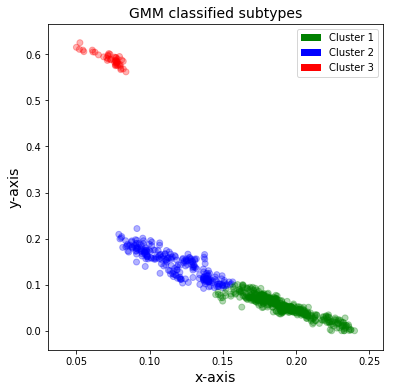

In [8]:
###Trial W
###Plotting without the distributions 
model_gmm_W = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm_W.fit(NMF_2D_W) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm_W = pd.DataFrame(model_gmm_W.predict(NMF_2D_W))

f = plt.figure(figsize=(6, 6))
ax = f.add_subplot(1, 1, 1)
colors_W = pd.DataFrame(Predict_gmm_W.replace([0,1,2],['blue', 'red','green']))
ax.scatter(NMF_2D_W[:, 0], NMF_2D_W[:, 1], c = colors_W.iloc[:,0], alpha=0.3)
ax.grid(False)
ax.set_xlabel('x-axis', fontsize = 14)
ax.set_ylabel('y-axis', fontsize = 14)
ax.set_title("GMM classified subtypes", fontsize = 14)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1,p2,p3), ('Cluster 1','Cluster 2','Cluster 3'), loc='best')
# ax.legend((p1,p3), ('Low', 'High'), loc='best')
plt.savefig(path + '..\\MSprogression\\NMF2D_gmm_trialW.png',dpi = 250)   

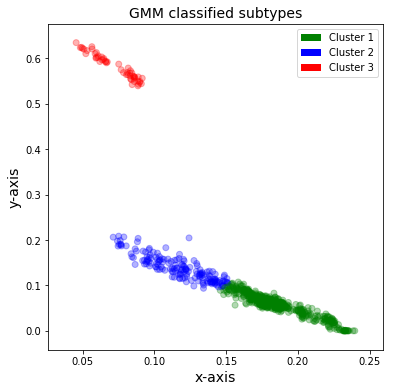

In [9]:
####Trial WT
###Plotting without the distributions 
model_gmm_WT = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm_WT.fit(NMF_2D_WT) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm_WT = pd.DataFrame(model_gmm_WT.predict(NMF_2D_WT))

f = plt.figure(figsize=(6, 6))
ax = f.add_subplot(1, 1, 1)
colors_WT = pd.DataFrame(Predict_gmm_WT.replace([0,1,2],['green', 'red','blue']))
ax.scatter(NMF_2D_WT[:, 0], NMF_2D_WT[:, 1], c = colors_WT.iloc[:,0], alpha=0.3)
ax.grid(False)
ax.set_xlabel('x-axis', fontsize = 14)
ax.set_ylabel('y-axis', fontsize = 14)
ax.set_title("GMM classified subtypes", fontsize = 14)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1,p2,p3), ('Cluster 1','Cluster 2','Cluster 3'), loc='best')
# ax.legend((p1,p3), ('Low', 'High'), loc='best')
plt.savefig(path + '..\\MSprogression\\NMF2D_gmm_trialWT.png',dpi = 250)   

In [10]:
###Trial W
NMF2D_added_colors_W = pd.DataFrame(NMF_2D_W, colors_W.iloc[:, 0])
NMF2D_added_colors_W.columns = ['NMFx', 'NMFy']

x_green_W = NMF2D_added_colors_W.loc[NMF2D_added_colors_W.index=='green']['NMFx'].values
y_green_W = NMF2D_added_colors_W.loc[NMF2D_added_colors_W.index=='green']['NMFy'].values

x_red_W = NMF2D_added_colors_W.loc[NMF2D_added_colors_W.index=='red']['NMFx'].values
y_red_W = NMF2D_added_colors_W.loc[NMF2D_added_colors_W.index=='red']['NMFy'].values

x_blue_W = NMF2D_added_colors_W.loc[NMF2D_added_colors_W.index=='blue']['NMFx'].values
y_blue_W = NMF2D_added_colors_W.loc[NMF2D_added_colors_W.index=='blue']['NMFy'].values



In [11]:
####Trial WT
NMF2D_added_colors_WT = pd.DataFrame(NMF_2D_WT, colors.iloc[:, 0])
NMF2D_added_colors_WT.columns = ['NMFx', 'NMFy']

x_green_WT = NMF2D_added_colors_WT.loc[NMF2D_added_colors_WT.index=='green']['NMFx'].values
y_green_WT = NMF2D_added_colors_WT.loc[NMF2D_added_colors_WT.index=='green']['NMFy'].values

x_red_WT = NMF2D_added_colors_WT.loc[NMF2D_added_colors_WT.index=='red']['NMFx'].values
y_red_WT = NMF2D_added_colors_WT.loc[NMF2D_added_colors_WT.index=='red']['NMFy'].values

x_blue_WT = NMF2D_added_colors_WT.loc[NMF2D_added_colors_WT.index=='blue']['NMFx'].values
y_blue_WT = NMF2D_added_colors_WT.loc[NMF2D_added_colors_WT.index=='blue']['NMFy'].values



NameError: name 'colors' is not defined

NameError: name 'x_blue_WT' is not defined

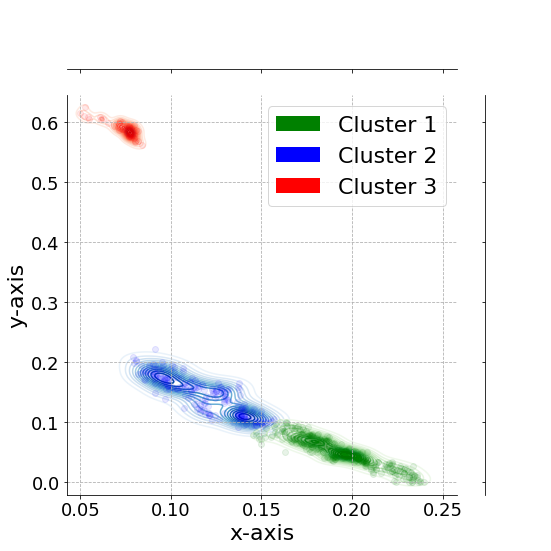

In [12]:
###Plotting with the distributions
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.spines.right'] = True

plt.rcParams['font.size'] = 18
a = 0.09
zo=0
l=15
p = sns.JointGrid(x = x_blue_W, y = y_blue_W, size = 8)
p.x = list(x_blue_W)
p.y = list(y_blue_W)
p.plot_joint(plt.scatter, c="b", alpha = a)
# p.ax_marg_x.hist(-x_hc, alpha = 0.5, color='r')
# p.ax_marg_y.hist(y_hc, orientation = 'horizontal', alpha = 0.5, color='r')
# p.plot_marginals(sns.distplot, color='b', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Blues")

p.x = list( x_red_W)
p.y = list( y_red_W)
p.plot_joint(plt.scatter, c="r", alpha = a)
# p.plot_marginals(sns.distplot, color='r', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")

p.x = list( x_green_W)
p.y = list( y_green_W)
p.plot_joint(plt.scatter, c="g", alpha = a)
# p.plot_marginals(sns.distplot, color='g', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
plt.grid()
# p.set_axis_labels(xlabel='Cognitive decline', ylabel='Memory decline')
# p.ax_joint.set_xticklabels([])
# p.ax_joint.set_yticklabels([])
# p.ax_marg_x.legend_.remove()

p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
plt.legend((p1,p2,p3), ('Cluster 1','Cluster 2','Cluster 3'), loc='best', fontsize = 22)
# plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
# plt.title('Trial W', fontsize = 14)
plt.xlabel('x-axis', fontsize = 22)
plt.ylabel('y-axis', fontsize = 22)
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(path + '..\\MSprogression\\NMF2D_gmm_trialW_distributions.png',dpi = 250)  

###Plotting with the distributions
p = sns.JointGrid(x = x_blue_WT, y = y_blue_WT, size = 8)
p.x = list(x_blue_WT)
p.y = list(y_blue_WT)
p = p.plot_joint(plt.scatter, c="b", alpha = a)
# p.ax_marg_x.hist(-x_hc, alpha = 0.5, color='r')
# p.ax_marg_y.hist(y_hc, orientation = 'horizontal', alpha = 0.5, color='r')
# p.plot_marginals(sns.distplot, color='b', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Blues")

p.x = list( x_red_WT)
p.y = list( y_red_WT)
p.plot_joint(plt.scatter, c="r", alpha = a)
# p.plot_marginals(sns.distplot, color='r', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")

p.x = list( x_green_WT)
p.y = list( y_green_WT)
p.plot_joint(plt.scatter, c="g", alpha = a)
# p.plot_marginals(sns.distplot, color='g', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
plt.grid()
# p.set_axis_labels(xlabel='Cognitive decline', ylabel='Memory decline')
# p.ax_joint.set_xticklabels([])
# p.ax_joint.set_yticklabels([])
# p.ax_marg_x.legend_.remove()

p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
plt.legend((p1,p2,p3), ('Cluster 1','Cluster 2','Cluster 3'), loc='best', fontsize = 22)
# plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
# plt.title('Trial W', fontsize = 14)
plt.xlabel('x-axis', fontsize = 22)
plt.ylabel('y-axis', fontsize = 22)
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(path + '..\\MSprogression\\NMF2D_gmm_trialWT_distributions.png',dpi = 250)  

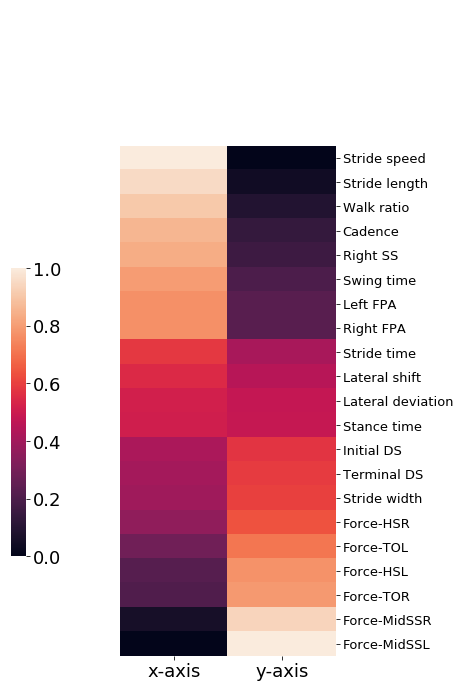

In [16]:
#Trial W
### Axis labels 
feature_display_names_21 = ['Stride time', 'Stance time', 'Swing time', 'Right SS', 'Initial DS', 'Terminal DS', 'Cadence',
       'Stride length', 'Stride width', 'Left FPA', 'Right FPA', 'Stride speed', 'Walk ratio', 'Force-HSR', 'Force-TOL', 'Force-MidSSR', 'Force-HSL',
       'Force-TOR', 'Force-MidSSL', 'Lateral shift', 'Lateral deviation']

H = model_NMF_W.components_
H_columns = regressN_df_normal.columns
M_H = pd.DataFrame(columns=H_columns)
M_H.loc[0] = H[0,:]
M_H.loc[1] = H[1,:]
M_H_T = M_H.T
M_H_T.index = feature_display_names_21
M_H_T.columns = ['axis 1','axis 2']
M_H_T = pd.DataFrame(M_H_T)
M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
M_H_T['new'] = 0
M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+(M_H_T['axis 2'] *0.05) ) \
                           else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +(M_H_T['axis 1']*0.05) ) else 'ambigious', axis=1)
M_H_T2 = M_H_T
M_H_T.to_csv(path + '..\\MSprogression\\NMF_trialW_factorize.csv') 
# M_H_T3 = M_H_T.sort_values(by='axis 1',ascending=False)
M_H_T3 = M_H_T.iloc[:, :2].sort_values(by='axis 1',ascending=False)
M_H_T3.columns = ['x-axis','y-axis']
cg = sns.clustermap(data=M_H_T3.fillna(0), col_cluster=False, row_cluster = False, figsize=(7, 10), standard_scale=1, \
                   cbar_pos=(0, .2, .03, .4), vmin = 0, vmax = 1)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=13)
# plt.setp(feature_display_names)
# plt.title('all features ', fontsize=40)
# plt.tight_layout()
plt.savefig(path + '..\\MSprogression\\NMF_factorize_trialW.png', dpi = 250,transparent=True)
plt.show()

In [17]:
M_H_T3

,x-axis,y-axis
Stride speed,1.000000,0.000000
Stride length,0.954456,0.045544
Walk ratio,0.906734,0.093266
Cadence,0.861741,0.138259
Right SS,0.836329,0.163671
Swing time,0.800313,0.199687
Left FPA,0.772396,0.227604
Right FPA,0.770325,0.229675
Stride time,0.584733,0.415267
Lateral shift,0.548356,0.451644


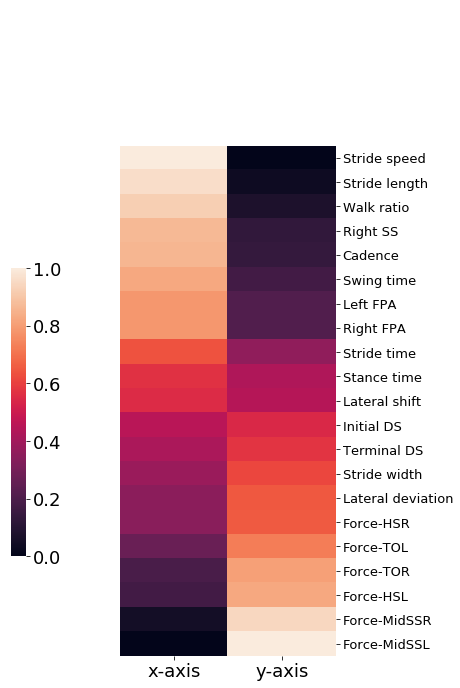

In [24]:
#Trial WT
### Axis labels 
feature_display_names_21 = ['Stride time', 'Stance time', 'Swing time', 'Right SS', 'Initial DS', 'Terminal DS', 'Cadence',
       'Stride length', 'Stride width', 'Left FPA', 'Right FPA', 'Stride speed', 'Walk ratio', 'Force-HSR', 'Force-TOL', 'Force-MidSSR', 'Force-HSL',
       'Force-TOR', 'Force-MidSSL', 'Lateral shift', 'Lateral deviation']

H = model_NMF_WT.components_
H_columns = regressN_df_normal.columns
M_H = pd.DataFrame(columns=H_columns)
M_H.loc[0] = H[0,:]
M_H.loc[1] = H[1,:]
M_H_T = M_H.T
M_H_T.index = feature_display_names_21
M_H_T.columns = ['axis 1','axis 2']
M_H_T = pd.DataFrame(M_H_T)
M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
M_H_T['new'] = 0
M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+(M_H_T['axis 2'] *0.05) ) \
                           else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +(M_H_T['axis 1']*0.05) ) else 'ambigious', axis=1)
M_H_T2 = M_H_T
M_H_T.to_csv(path + '..\\MSprogression\\NMF_trialWT_factorize.csv') 
# M_H_T3 = M_H_T.sort_values(by='axis 1',ascending=False)
M_H_T3 = M_H_T.iloc[:, :2].sort_values(by='axis 1',ascending=False)
M_H_T3.columns = ['x-axis','y-axis']
cg = sns.clustermap(data=M_H_T3.fillna(0), col_cluster=False, row_cluster = False, figsize=(7, 10), standard_scale=1, \
                   cbar_pos=(0, .2, .03, .4), vmin = 0, vmax = 1)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=13)
# plt.setp(feature_display_names)
# plt.title('all features ', fontsize=40)
# plt.tight_layout()
plt.savefig(path + '..\\MSprogression\\NMF_factorize_trialWT.png', dpi = 250,transparent=True)
plt.show()

In [19]:
M_H_T3

,x-axis,y-axis
Stride speed,1.000000,0.000000
Stride length,0.963029,0.036971
Walk ratio,0.922687,0.077313
Right SS,0.867280,0.132720
Cadence,0.862272,0.137728
Swing time,0.825537,0.174463
Left FPA,0.788093,0.211907
Right FPA,0.786737,0.213263
Stride time,0.639026,0.360974
Stance time,0.568159,0.431841


### Count and values of EDSS in each cluster 

In [20]:
#Trial W
#Count and values of EDSS in each cluster 
gmm_predictions_W = pd.DataFrame(data = Predict_gmm_W.values, columns = ['clusterID'])
gmm_predictions_W['edss'] = dataset_W['edss'].values

print ('Cluster Blue\n', gmm_predictions_W[gmm_predictions_W['clusterID']==0]['edss'].value_counts(dropna = False))
print ('\nCluster Red\n',gmm_predictions_W[gmm_predictions_W['clusterID']==1]['edss'].value_counts(dropna = False))
print ('\nCluster Green\n',gmm_predictions_W[gmm_predictions_W['clusterID']==2]['edss'].value_counts(dropna = False))


Cluster Blue
 6.0    175
5.5     29
3.5     10
4.0      9
2.0      8
1.5      5
3.0      4
1.0      4
Name: edss, dtype: int64

Cluster Red
 5.0    46
Name: edss, dtype: int64

Cluster Green
 3.5    121
3.0    117
4.0     79
1.5     52
1.0     48
2.0     31
6.0     11
Name: edss, dtype: int64


In [21]:
#Trial WT
#Count and values of EDSS in each cluster 
gmm_predictions_WT = pd.DataFrame(data = Predict_gmm_WT.values, columns = ['clusterID'])
gmm_predictions_WT['edss'] = dataset_WT['edss'].values

print ('Cluster Green\n', gmm_predictions_WT[gmm_predictions_WT['clusterID']==0]['edss'].value_counts(dropna = False))
print ('\nCluster Red\n',gmm_predictions_WT[gmm_predictions_WT['clusterID']==1]['edss'].value_counts(dropna = False))
print ('\nCluster Blue\n',gmm_predictions_WT[gmm_predictions_WT['clusterID']==2]['edss'].value_counts(dropna = False))


Cluster Green
 3.5    121
3.0    107
4.0     80
1.0     55
1.5     48
2.0     46
6.0     18
Name: edss, dtype: int64

Cluster Red
 5.0    52
Name: edss, dtype: int64

Cluster Blue
 6.0    137
5.5     11
1.5      7
4.0      6
3.5      4
1.0      3
2.0      2
3.0      1
Name: edss, dtype: int64


### BIC to find the optimal number of clusters for GMM

[-4088.08430972 -6897.04504248 -7186.92636621 -7264.41784153
 -7266.76693462 -7256.95616875 -7269.289911  ]


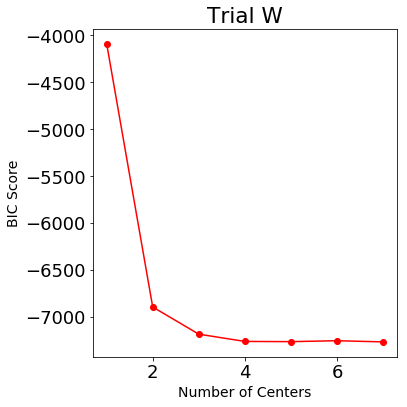

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
Nclusters = np.arange(1, 8)
# find best number of clusters via BIC
clfs = [mixture.GaussianMixture(n_components=N, covariance_type='tied').fit(NMF_2D_W) for N in Nclusters]
BICs = np.array([clf.bic(NMF_2D_W) for clf in clfs])
clf = clfs[np.argmin(BICs)]
print(BICs)

# scatter the points
ax.plot(Nclusters, BICs, 'ro-') 
plt.xlabel('Number of Centers', fontsize = 14)
plt.ylabel('BIC Score', fontsize = 14)
plt.title ('Trial W')
plt.tight_layout()
plt.savefig(path + '..\\MSprogression\\bic_trialW.png',dpi = 250) 
plt.show()

[-3817.8522319  -6667.57503447 -6744.97775743 -6788.64361492
 -6786.71790707 -6812.14307175 -6792.76649494]


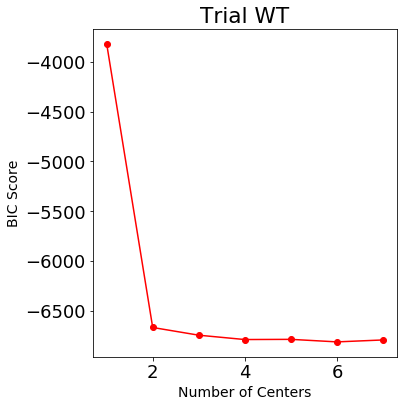

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
Nclusters = np.arange(1, 8)
# find best number of clusters via BIC
clfs = [mixture.GaussianMixture(n_components=N, covariance_type='tied').fit(NMF_2D_WT) for N in Nclusters]
BICs = np.array([clf.bic(NMF_2D_WT) for clf in clfs])
clf = clfs[np.argmin(BICs)]
print(BICs)

# scatter the points
ax.plot(Nclusters, BICs, 'ro-') 
plt.xlabel('Number of Centers', fontsize = 14)
plt.ylabel('BIC Score', fontsize = 14)
plt.title ('Trial WT')
plt.tight_layout()
plt.savefig(path + '..\\MSprogression\\bic_trialWT.png',dpi = 250) 
plt.show()